In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [4]:
# MNIST IMAGE --> Tensors
transform = transforms.ToTensor()

In [5]:
train_data = datasets.MNIST(root='./data/', train=True, download=True, transform=transform)

In [6]:
test_data = datasets.MNIST(root='./data/', train=False, download=True, transform=transform)

In [7]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [10]:
type(test_data)

torchvision.datasets.mnist.MNIST

In [11]:
type(train_data[0])

tuple

In [12]:
image, label = train_data[0]

In [13]:
label

5

In [14]:
image.shape

torch.Size([1, 28, 28])

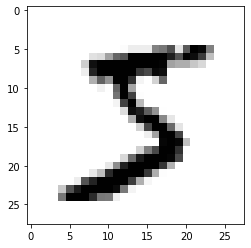

In [15]:
plt.imshow(image.reshape((28,28)), cmap='gist_yarg') #viridis

In [16]:
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [17]:
from torchvision.utils import make_grid

In [18]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))

In [19]:
# FIRST BATCH 
for images, labels in train_loader:
    # 60,000 / 100 = 60 times
    break

In [20]:
images.shape

torch.Size([100, 1, 28, 28])

In [21]:
labels.shape

torch.Size([100])

In [22]:
# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

Labels:  [   2    4    0    4    0    8    1    5    1    3    0    3]


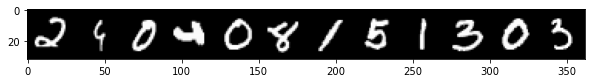

In [23]:
# Print the first 12 images
im = make_grid(images[:12], nrow=12) # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

Labels:  [   2    4    0    4    0    8    1    5    1    3    0    3]


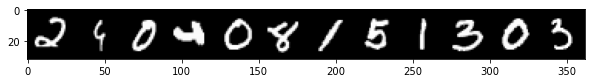

In [24]:
# Print the first 12 labels
print('Labels: ', labels[:12].numpy())
# Print the first 12 images
im = make_grid(images[:12], nrow=12) # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [25]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [26]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (flatten): Flatten()
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [27]:
# ANN ---> CNN

for param in model.parameters():
    print(param.numel())

94080
120
10080
84
840
10


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
images.shape

torch.Size([100, 1, 28, 28])

In [30]:
images.view(100, -1).shape

torch.Size([100, 784])

In [31]:
%%time

epochs = 10

#Trackers
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        
        b += 1
        
        y_pred = model(X_train.view(100, -1))
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            acc = trn_corr.item()*100/(100*b)
            print(f'Epoch: {i+1} batch: {b} loss: {loss.item():.15f} accuracy: {acc:.3f}')
    
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            
            y_val = model(X_test.view(500, -1))
            
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

Epoch: 1 batch: 200 loss: 0.275825828313828 accuracy: 83.090
Epoch: 1 batch: 400 loss: 0.216715484857559 accuracy: 87.373
Epoch: 1 batch: 600 loss: 0.214036539196968 accuracy: 89.393
Epoch: 2 batch: 200 loss: 0.137863978743553 accuracy: 94.670
Epoch: 2 batch: 400 loss: 0.123864248394966 accuracy: 95.168
Epoch: 2 batch: 600 loss: 0.116839781403542 accuracy: 95.412
Epoch: 3 batch: 200 loss: 0.129937201738358 accuracy: 96.565
Epoch: 3 batch: 400 loss: 0.087659120559692 accuracy: 96.672
Epoch: 3 batch: 600 loss: 0.100277565419674 accuracy: 96.743
Epoch: 4 batch: 200 loss: 0.042302813380957 accuracy: 97.605
Epoch: 4 batch: 400 loss: 0.077305123209953 accuracy: 97.582
Epoch: 4 batch: 600 loss: 0.044224571436644 accuracy: 97.575
Epoch: 5 batch: 200 loss: 0.149955809116364 accuracy: 97.930
Epoch: 5 batch: 400 loss: 0.097628571093082 accuracy: 98.010
Epoch: 5 batch: 600 loss: 0.139723673462868 accuracy: 98.033
Epoch: 6 batch: 200 loss: 0.053183790296316 accuracy: 98.370
Epoch: 6 batch: 400 loss

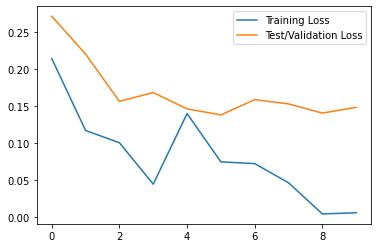

In [32]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test/Validation Loss')
plt.legend()

In [33]:
train_acc = [t/600 for t in train_correct]

..\aten\src\ATen\native\BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


In [34]:
test_acc =[t/600 for t in test_correct]

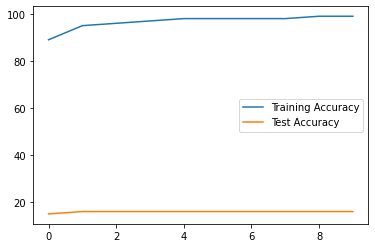

In [35]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.legend()

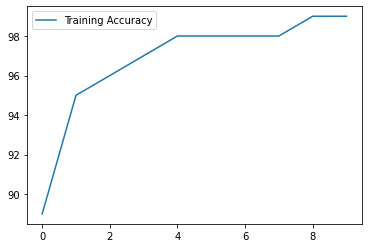

In [36]:
plt.plot(train_acc, label='Training Accuracy')
plt.legend()

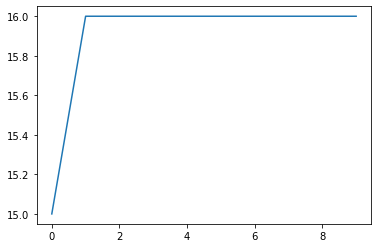

In [37]:
plt.plot(test_acc, label='Test Accuracy')

In [38]:
# NEW UNSEEN DATA
test_load_all = DataLoader(test_data, batch_size=10000, shuffle = False)
with torch.no_grad():
    correct = 0
    
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [39]:
100*correct.item()/len(test_data)

97.63

In [40]:
confusion_matrix(predicted.view(-1), y_test.view(-1))

array([[ 967,    0,    2,    1,    2,    2,    6,    0,    6,    1],
       [   0, 1121,    0,    0,    0,    0,    4,    3,    0,    3],
       [   1,    4, 1008,    0,    0,    0,    1,   10,    2,    1],
       [   2,    2,    6,  999,    1,   17,    1,    2,   11,    9],
       [   1,    0,    2,    0,  955,    1,    6,    0,    2,   10],
       [   1,    0,    0,    2,    0,  864,    7,    0,    5,    4],
       [   1,    1,    2,    0,    6,    3,  931,    0,    1,    1],
       [   1,    0,    3,    4,    3,    0,    1, 1009,    2,   10],
       [   5,    7,    9,    3,    2,    5,    1,    2,  943,    4],
       [   1,    0,    0,    1,   13,    0,    0,    2,    2,  966]],
      dtype=int64)